In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import xarray as xr
import netCDF4
from global_land_mask import globe
import matplotlib as mpl
from scipy.optimize import curve_fit
import metpy.calc as mpcalc
from metpy.units import units
import scipy
import metpy
mpl.rcParams['figure.dpi']= 300

g = 9.80616
Cp = 1004.64
Lv = 2.501e6
#R = 8.34
R = 287

In [52]:
c = '/media/rakshith/Seagate Expansion Drive/mraks/MSE India.nc'
ds3 = xr.open_dataset(c)

f1 = netCDF4.Dataset(c)

lon_grid1, lat_grid1 = np.meshgrid(ds3.longitude, ds3.latitude)
mask1 = globe.is_land(lat_grid1, lon_grid1)

h = '/media/rakshith/Seagate Expansion Drive/mraks/TGMS ERA 1959-2021, India only.nc'
#h = '/media/rakshith/Windows/Users/mraks/TGMS ERA 1959-2021, India only.nc'
ds = xr.open_dataset(h)

In [21]:
jjas = ds3.time.dt.month.isin(range(6, 10)) #JJAS
clim = ds3.sel(time=jjas)

clim = clim.groupby('time.year').mean('time')

#clim = ds3 #for all months
ds4 = clim.sel(level=slice(100,1000)).where(mask1>0).mean(dim=['latitude', 'longitude']).squeeze()
#selecting only till level 100mb

In [40]:
jjas = ds.time.dt.month.isin(range(6, 10)) #JJAS
clim = ds.sel(time=jjas)

clim = clim.groupby('time.year').mean('time')

clim=clim.where(mask1>0).mean(dim=['latitude', 'longitude']) #for all months
Pwat = clim.tcwv
Qdiv = clim.mtnswrf + clim.mtnlwrf + clim.mslhf + clim.msshf + clim.msnswrf + clim.msnlwrf
P = 86400*28.96*(clim.mtpr+clim.mer)
E = -86400*28.96*(clim.mer)
Pr = 86400*clim.mtpr

In [23]:
q = ds4.q
q0 = q.sel(level=1000)
divq = np.divide(q,q0)

p=100*ds4.level
p0=100000
divp = np.divide(p,p0)

T = ds4.t
T0 = T.sel(level=1000)

z=ds4.z/g

In [ ]:
from sklearn.linear_model import LinearRegression
regr = LinearRegression()
gammalist=[]
lambdalist=[]
for k in ds4.time:
    x1, y1 = np.log(divq.sel(time=k)).values.reshape(-1, 1), np.log(divp).values.reshape(-1, 1)
    regr.fit(x1, y1)
    y_pred1 = regr.predict(x1)
    lambda1 = regr.coef_[0][0]
    lambdalist.append(lambda1)
    
    x2, y2 = z.sel(time=k).values.reshape(-1, 1), T.sel(time=k).values.reshape(-1, 1)
    regr.fit(x2, y2)
    y_pred2 = regr.predict(x2)
    gamma1 = regr.coef_[0][0]
    gammalist.append(gamma1) 

In [25]:
#Use this cell for year
from sklearn.linear_model import LinearRegression
regr = LinearRegression()
gammalist=[]
lambdalist=[]
for k in ds4.year:
    x1, y1 = np.log(divq.sel(year=k)).values.reshape(-1, 1), np.log(divp).values.reshape(-1, 1)
    regr.fit(x1, y1)
    y_pred1 = regr.predict(x1)
    lambda1 = regr.coef_[0][0]
    lambdalist.append(lambda1)
    
    x2, y2 = z.sel(year=k).values.reshape(-1, 1), T.sel(year=k).values.reshape(-1, 1)
    regr.fit(x2, y2)
    y_pred2 = regr.predict(x2)
    gamma1 = regr.coef_[0][0]
    gammalist.append(gamma1) 

In [26]:
lambdalist = np.divide(1,lambdalist)

In [27]:
gammalist = abs(np.array(gammalist))

In [9]:
l=lambdalist
a=g/(np.multiply(Cp, gammalist))
b=np.multiply(R, gammalist)/g

p0=100000
num = p0*(a-1)*b*(np.array(l)+2)*Cp*T0
den = Lv*g*np.array(l)*(b+1)*(b+2)
del1 = num/(den*Pwatint)

constref = np.average(num/den)

const = num/den
constref

70.61476192550508

In [20]:
x2, y2 = Pwatint, del1

def objective2(x0, c0):
    return c0/x0

p0=72.2
popt2, _ = curve_fit(objective2, x2, y2, p0, maxfev=800, bounds=(0, 1E5))
c2 = popt2

print('y = %.10f /Pwat' % (c2)) 

x_line = np.linspace(np.min(x2), np.max(x2), 100)
y_line2 = objective2(x_line,c2)

y = 72.1214736952 /Pwat


In [21]:
delcal = objective2(x2, c2)

from sklearn.metrics import mean_squared_error
rmse = mean_squared_error(del1, delcal, squared=False)
print(rmse)

0.19610024841059628


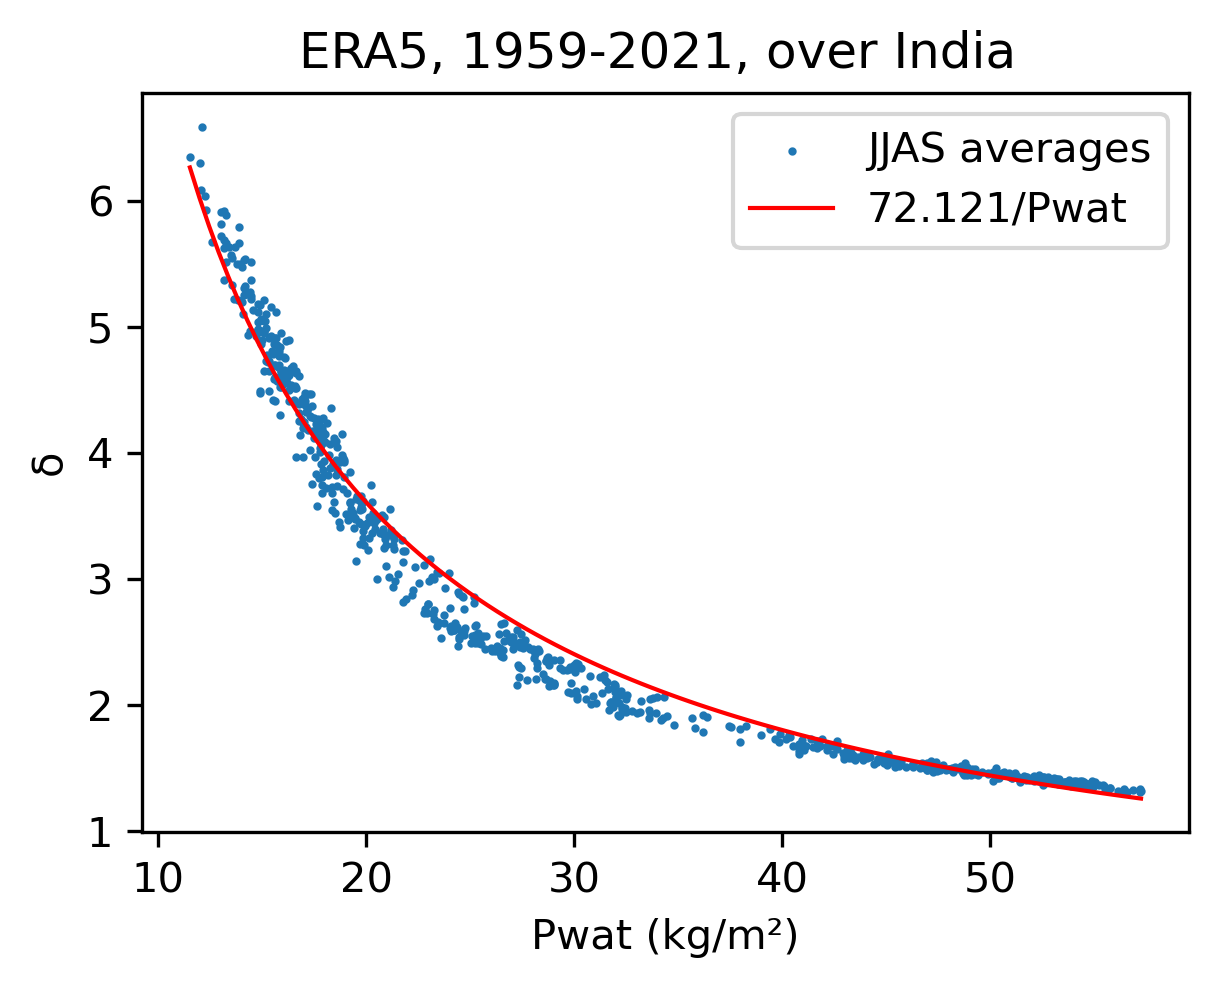

In [22]:
plt.rcParams['figure.figsize'] = [4.5,3.2]
plt.scatter(Pwatint, del1, s=1, label='JJAS averages')
plt.plot(x_line, y_line2, color='red', linewidth=1, label = "%.3f/Pwat" %(c2))
plt.xlabel('Pwat (kg/m\u00b2)')
plt.ylabel('\u03B4')
plt.title('ERA5, 1959-2021, over India ')
plt.legend()

In [40]:
metpy.constants.dry_air_gas_constant

287.04749097718457 <Unit('joule / kelvin / kilogram')>

In [41]:
metpy.constants.earth_gravity

9.80665 <Unit('meter / second ** 2')>

In [42]:
metpy.constants.water_heat_vaporization

2500840.0 <Unit('joule / kilogram')>

In [43]:
metpy.constants.dry_air_spec_heat_press

1004.6662184201462 <Unit('joule / kelvin / kilogram')>

# Plot

In [23]:
C = 72.121

In [39]:
clim0 = ds.sel(time=slice('2000', '2002'))
clim = clim0.where(mask1>0).mean(dim=['latitude', 'longitude'])
Pwat = clim.tcwv
E = -86400*28.96*clim.mer
P = 86400*(clim.mtpr)#+clim.mer)
Qdiv = clim.mtnswrf + clim.mtnlwrf + clim.mslhf + clim.msshf + clim.msnswrf + clim.msnlwrf

In [40]:
Pcal = (E+Qdiv/((C/Pwat)-1))/28.96

In [41]:
from sklearn.metrics import mean_squared_error

rmse = mean_squared_error(P, Pcal, squared=False)
print(rmse)

1.2002760276328628


Text(0.35, 0.8, 'RMSE = 1.20 mm/day')

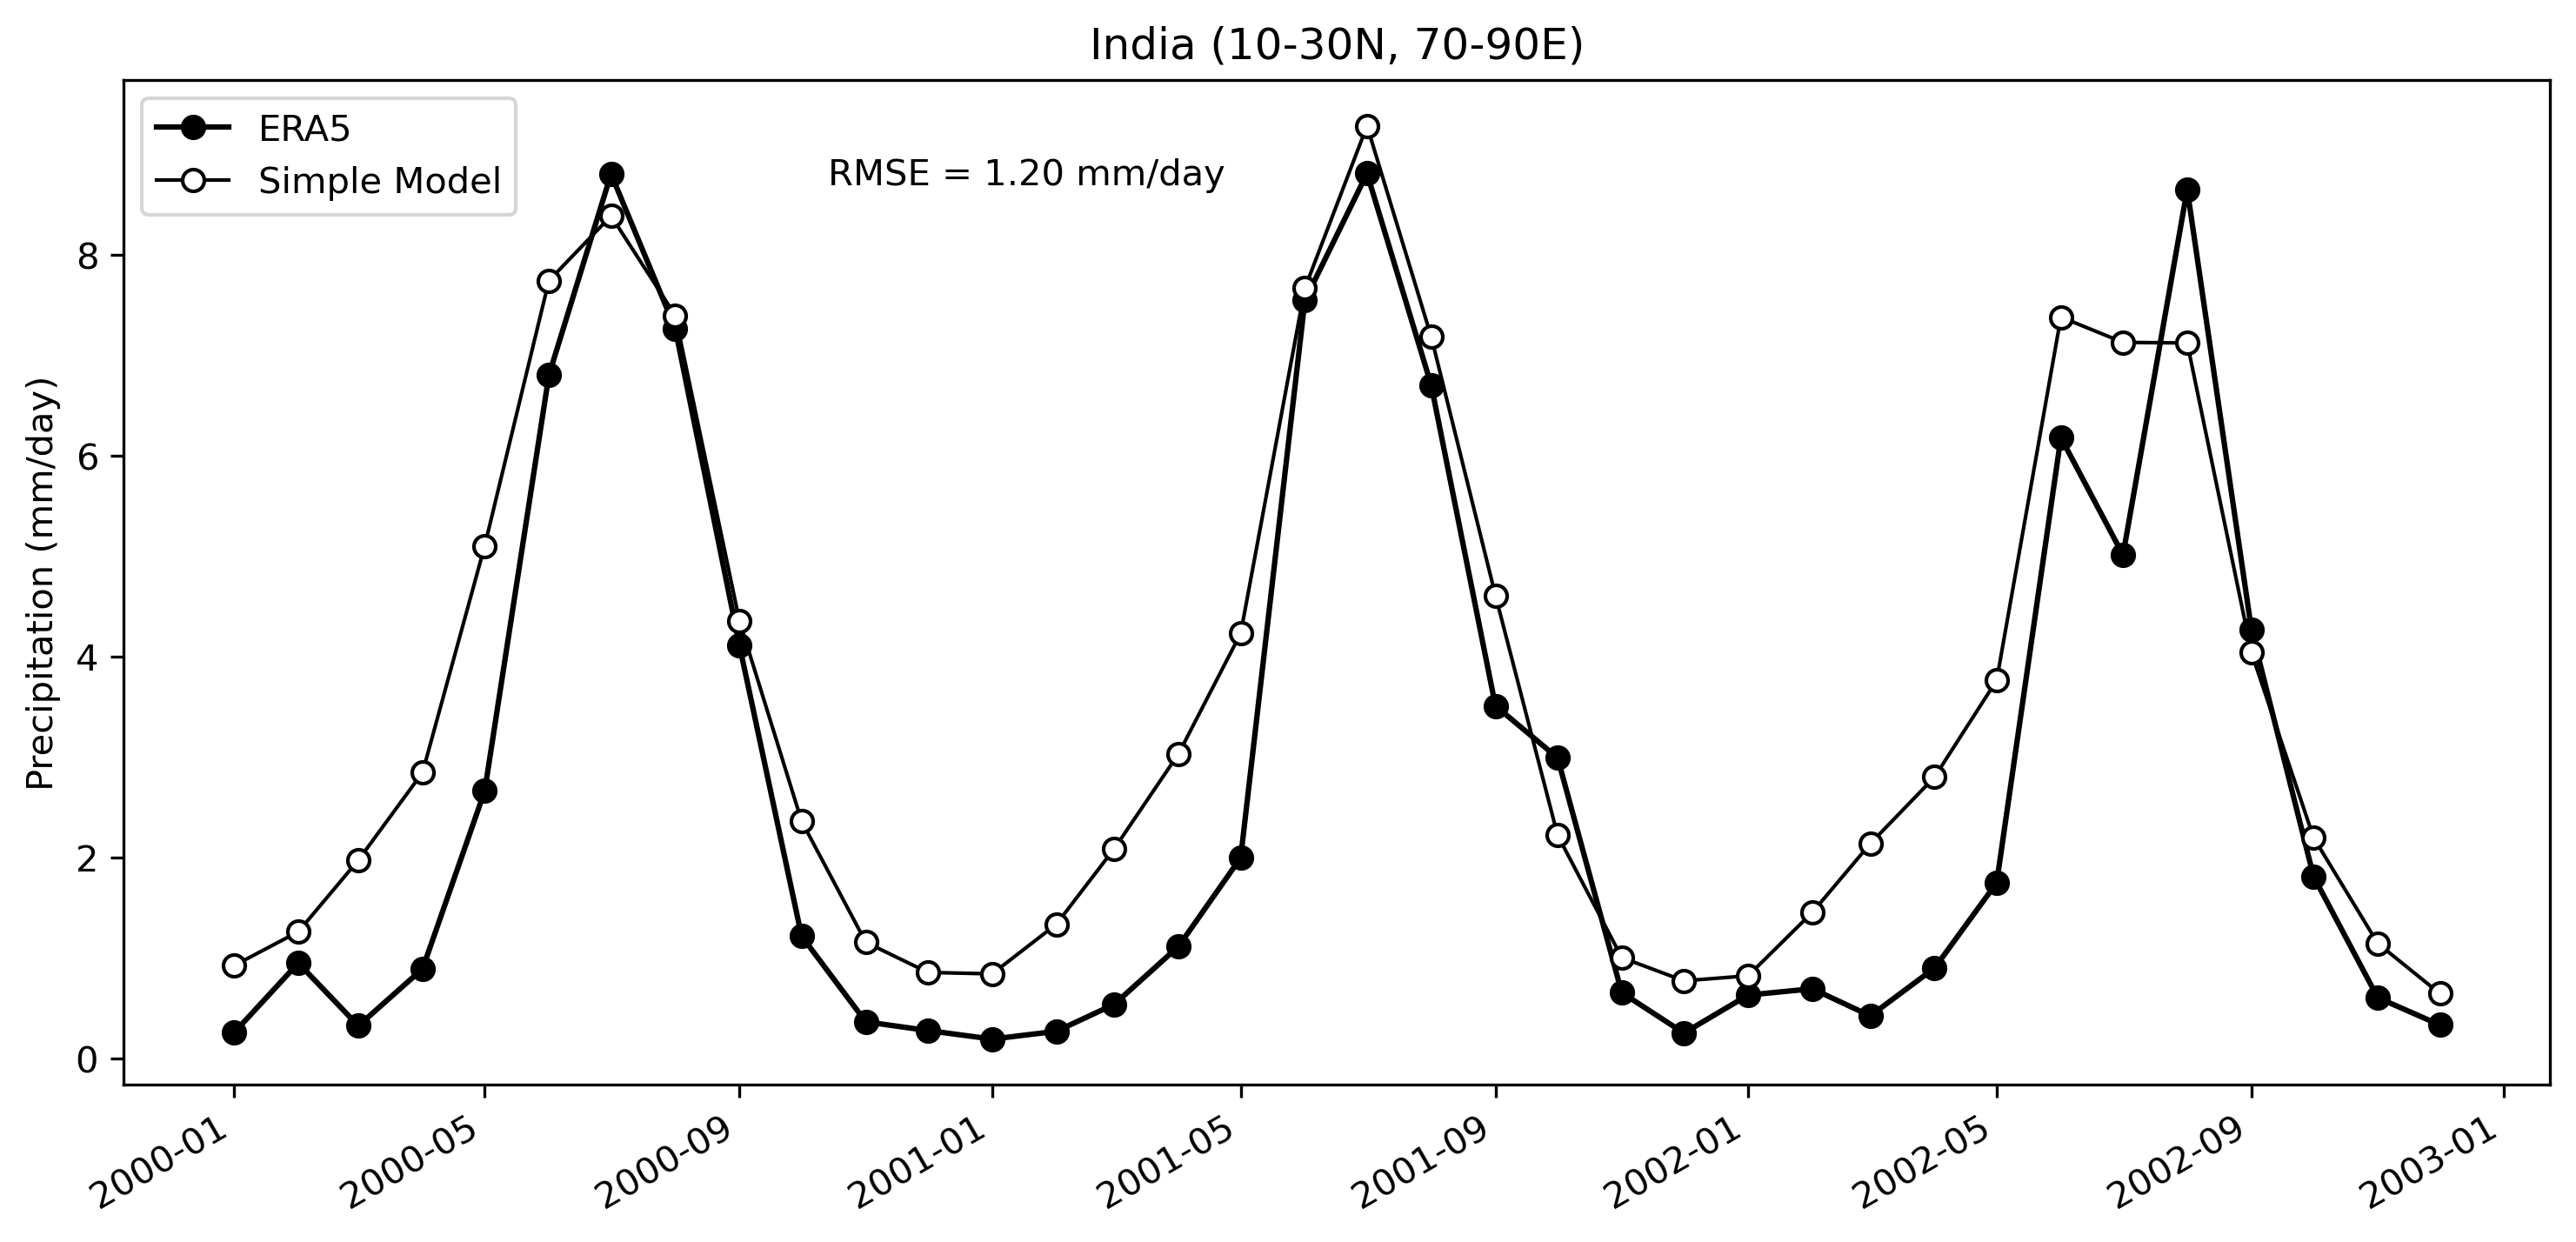

In [42]:
plt.rcParams['figure.figsize'] = [12,5]
P.plot(c='black', marker='o', label='ERA5')
Pcal.plot(c='black', marker='o', markerfacecolor='white', linewidth=1, label='Simple Model')
plt.xlabel('')
plt.ylabel('Precipitation (mm/day)')
plt.legend()
plt.title('India (10-30N, 70-90E)')
plt.figtext(0.35, 0.8, 'RMSE = %.2f mm/day' %(rmse))

In [79]:
C = Pwat*((Qdiv/P)+1)

In [80]:
C

<xarray.DataArray (year: 63)>
array([65.556244, 68.497696, 67.07402 , 67.10123 , 67.61678 , 64.458275,
       63.982113, 67.79371 , 64.608665, 66.10117 , 70.68151 , 69.73606 ,
       67.311905, 71.53807 , 68.580215, 74.32556 , 67.008965, 67.43082 ,
       73.03973 , 69.36961 , 79.20939 , 68.768906, 72.76946 , 74.50333 ,
       70.51991 , 69.00954 , 74.847336, 69.84619 , 85.2421  , 70.798744,
       68.87855 , 68.14331 , 70.7612  , 71.049095, 69.96448 , 67.200806,
       72.44539 , 70.19993 , 70.43278 , 75.160965, 71.13382 , 71.53816 ,
       73.01109 , 73.09661 , 68.80725 , 73.24633 , 70.31682 , 70.130226,
       70.17398 , 68.95475 , 71.13895 , 71.15749 , 67.40535 , 70.13728 ,
       67.38159 , 71.21096 , 73.61222 , 69.38611 , 73.91782 , 70.25445 ,
       68.75643 , 72.41022 , 72.206856], dtype=float32)
Coordinates:
  * year     (year) int64 1959 1960 1961 1962 1963 ... 2017 2018 2019 2020 2021

In [83]:
size = 10

In [86]:
Cavg = [sum(group) / size for group in zip(*[iter(C.values)]*size)] #Decadal average
Gavg = [sum(group) / size for group in zip(*[iter(gammalist)]*size)]

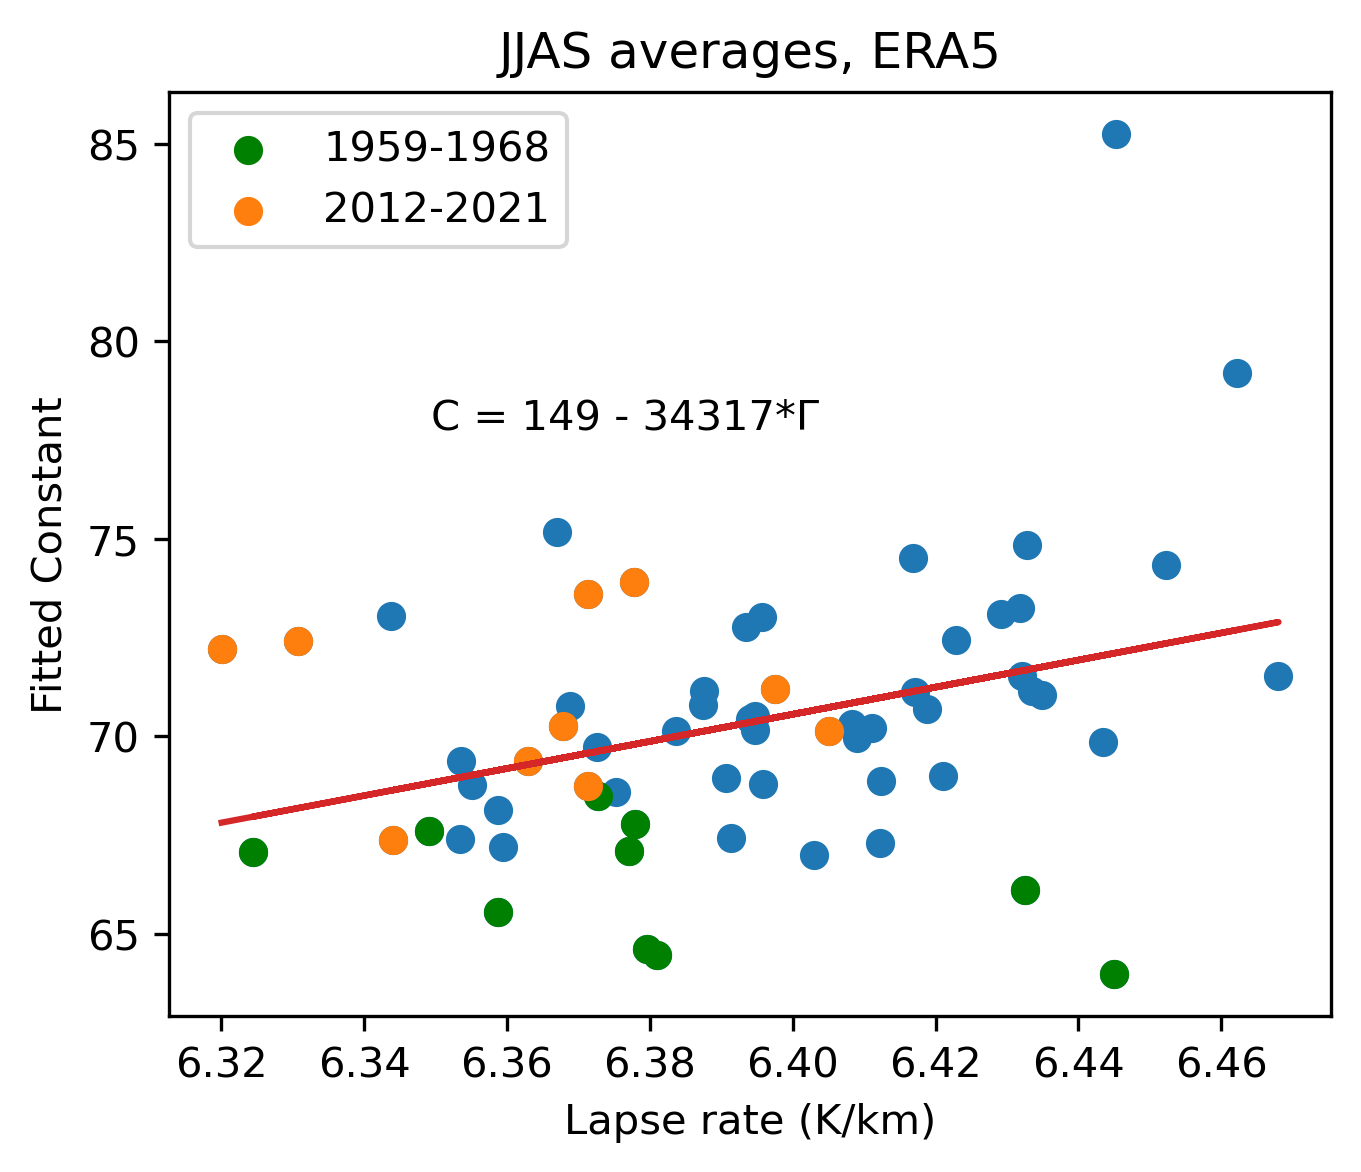

In [74]:
plt.rcParams['figure.figsize'] = [5,4]
def f(g, a, b):
    return a  + b * g

popt1, _ = curve_fit(f, gammalist, C)
a1, b1 = popt1

plt.scatter(1000*gammalist, C)
plt.scatter(1000*gammalist[:10], C[:10], c='green', label='1959-1968')
plt.scatter(1000*gammalist[-10:], C[-10:], c='tab:orange', label='2012-2021')
y_line1 = f(gammalist, a1, b1)
plt.plot(1000*gammalist, y_line1, c='tab:red')
plt.ylabel('Fitted Constant')
plt.xlabel('Lapse rate (K/km)')

plt.figtext(0.3, 0.6, 'C = %.0f - %.0f*\u0393' % (abs(a1), abs(b1)))
plt.title('JJAS averages, ERA5')
plt.legend()

In [57]:
C = y_line1

In [58]:
Pcal = (E + Qdiv/((C/Pwat)-1))/28.96

In [59]:
from sklearn.metrics import mean_squared_error

rmse = mean_squared_error(Pr, Pcal, squared=False)
print(rmse)

0.6024951558382262


In [60]:
X = np.linspace(1959, 2021, 63, dtype='int')

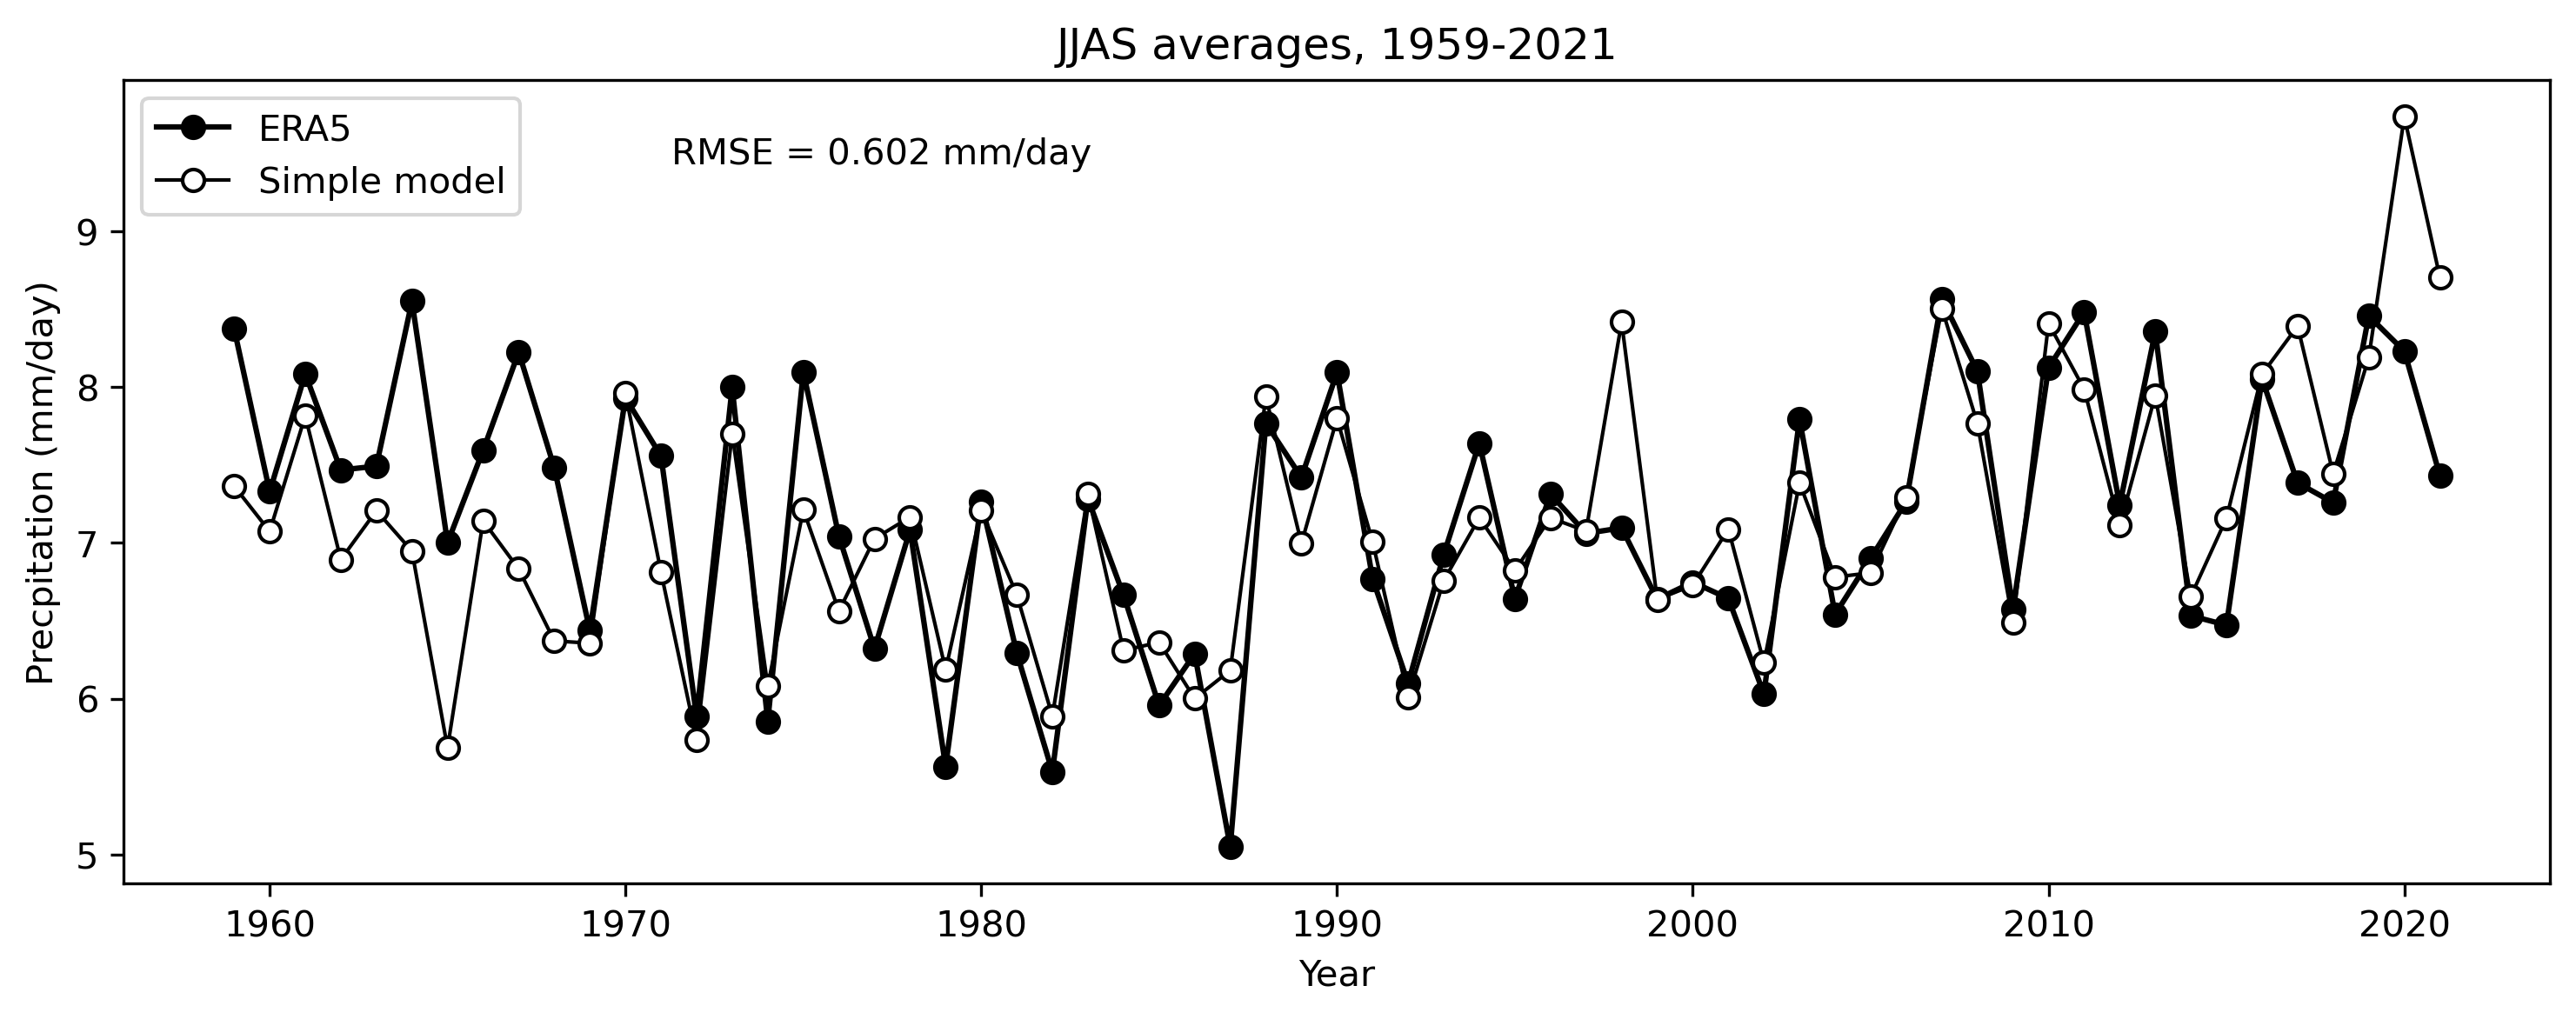

In [61]:
plt.rcParams['figure.figsize'] = [12,4]
plt.plot(X, Pr, color='black', label = 'ERA5', marker='o')
Pcal.plot(c='black', marker='o', markerfacecolor='white', linewidth=1, label='Simple model')
plt.xlabel('Year')
plt.ylabel('Precpitation (mm/day)')
plt.legend()
#plt.xticks(X, X)
#plt.xticks(rotation=90)
plt.figtext(0.3, 0.8, 'RMSE = %.3f mm/day' %(rmse))
plt.title('JJAS averages, 1959-2021')
plt.show()